In [1]:
import os
from tqdm import tqdm
import numpy as np
from pathlib import Path
import argparse
import logging
import torch
from torch.utils.data import DataLoader
import wandb
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (Trainer, TrainingArguments, DataCollatorWithPadding,
                          AutoTokenizer, AutoModelForSequenceClassification)

In [2]:
model_name_or_path = "microsoft/mpnet-base"
dataset_path = '../bin/aqag.hf'
output_dir = 'results/hp-tuning'
model_max_length = 512
eval_steps = 1000
eval_accumulation_steps = 2
save_total_limit = 4
batch_size = 32
num_epochs = 4
learning_rate = 3e-05
seed = 42
metric = 'accuracy'
entity = 'ai-aloe'
project_name = 'short answer scoring'

id2label = {0: "incorrect_answer", 1: "correct_answer"}
label2id = {"incorrect_answer": 0, "correct_answer": 1}

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    max_length=model_max_length,
    )

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                               num_labels=2,
                                                               id2label=id2label,
                                                               label2id=label2id)
    return model

In [20]:
def preprocess_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)
    
ds = DatasetDict.load_from_disk(dataset_path)
ds = ds.map(preprocess_function, batched=False)

Map:   0%|          | 0/2031 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/jovyan/active-projects/textbook-question-generation/bin/aqag.hf/valid/cache-503ff22a718521ab.arrow


Map:   0%|          | 0/444 [00:00<?, ? examples/s]

In [21]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

In [23]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/mpnet_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = True,
    seed=seed,
    log_level = 'error',  
    disable_tqdm = False, 
) 

    # Call the Trainer
trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = ds['train'],
    eval_dataset = ds['valid'],
    compute_metrics = compute_metrics
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.423891,0.841743
2,No log,0.234346,0.917431
3,No log,0.214871,0.933486
4,No log,0.234936,0.928899


TrainOutput(global_step=256, training_loss=0.279464989900589, metrics={'train_runtime': 241.1421, 'train_samples_per_second': 33.69, 'train_steps_per_second': 1.062, 'total_flos': 2137514213744640.0, 'train_loss': 0.279464989900589, 'epoch': 4.0})

In [24]:
preds, labels, metrics= trainer.predict(ds['test'])
predictions = np.argmax(preds, axis=1)

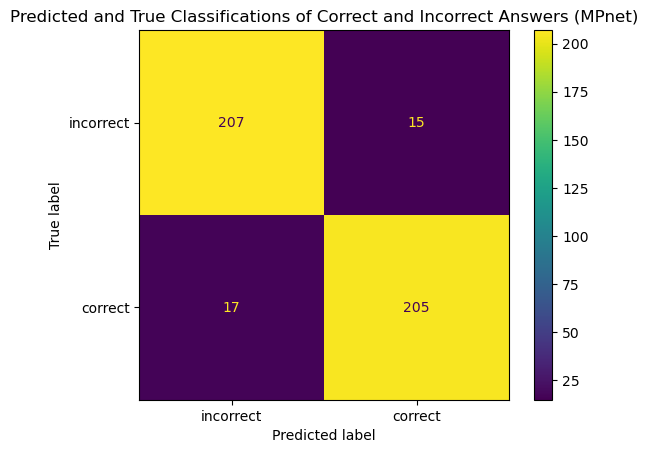

In [32]:
from sklearn import metrics
from matplotlib import pyplot as plt

confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (MPnet)')
plt.show()

In [26]:
print(metrics.classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       222
           1       0.93      0.92      0.93       222

    accuracy                           0.93       444
   macro avg       0.93      0.93      0.93       444
weighted avg       0.93      0.93      0.93       444



['Social media outlets like Facebook and Twitter are not a reliable source of information.</s>Social media outlets like Facebook and Twitter can provide us with valuable information that affects the decisions we make.',
 'Scarcity is when resources are infinite and human wants are limited.</s>Scarcity is a fact of life in which human wants for goods, services, and resources exceed what is available.',
 "The US Census Bureau database.</s>The St. Louis Federal Reserve Bank's FRED database.",
 'Microeconomics and macroeconomics are separate subjects.</s>Microeconomics and macroeconomics are complementary perspectives on the overall subject of the economy.',
 'Fiscal policy is about government spending and taxes.</s>Monetary policy affects bank lending, interest rates, and financial capital markets.',
 "The Cato Foundation's Human Freedom Index is a ranking of countries based on their level of economic freedom, similar to the Heritage Foundation's Index of Economic Freedom.</s>The Cato Fou